In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Load

In [15]:
import numpy as np

def load_data(filename):
  data_file = open(filename, 'r')  # Open File "to read"
  data_image = []  # List to hold Datapoint objects
  data_label = []
  for index, line in enumerate(data_file):
    if index!=0:
      label_tep,image_tep = line.split(',')
      image_tep = image_tep.split(' ')
      image_tep = list(np.int_(image_tep))
      data_label.append(int(label_tep))
      data_image.append(image_tep)
  image = np.array(data_image).reshape([-1,48,48])
  return np.array(data_label),image

In [16]:
test_data = ("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/Q2_Test_Data.csv")
train_data = ("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/Q2_Train_Data.csv")
valid_data = ("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/Q2_Validation_Data.csv")
test_labels,test_images = load_data(test_data)
train_labels,train_images = load_data(train_data)
valid_labels,valid_images = load_data(valid_data)

# 2(a)

Train Image Shape:  (28709, 48, 48) Train Label Shape:  (28709,)
Valid Image Shape:  (3589, 48, 48) Valid Label Shape:  (3589,)
Test Image Shape:  (3589, 48, 48) Test Label Shape:  (3589,)


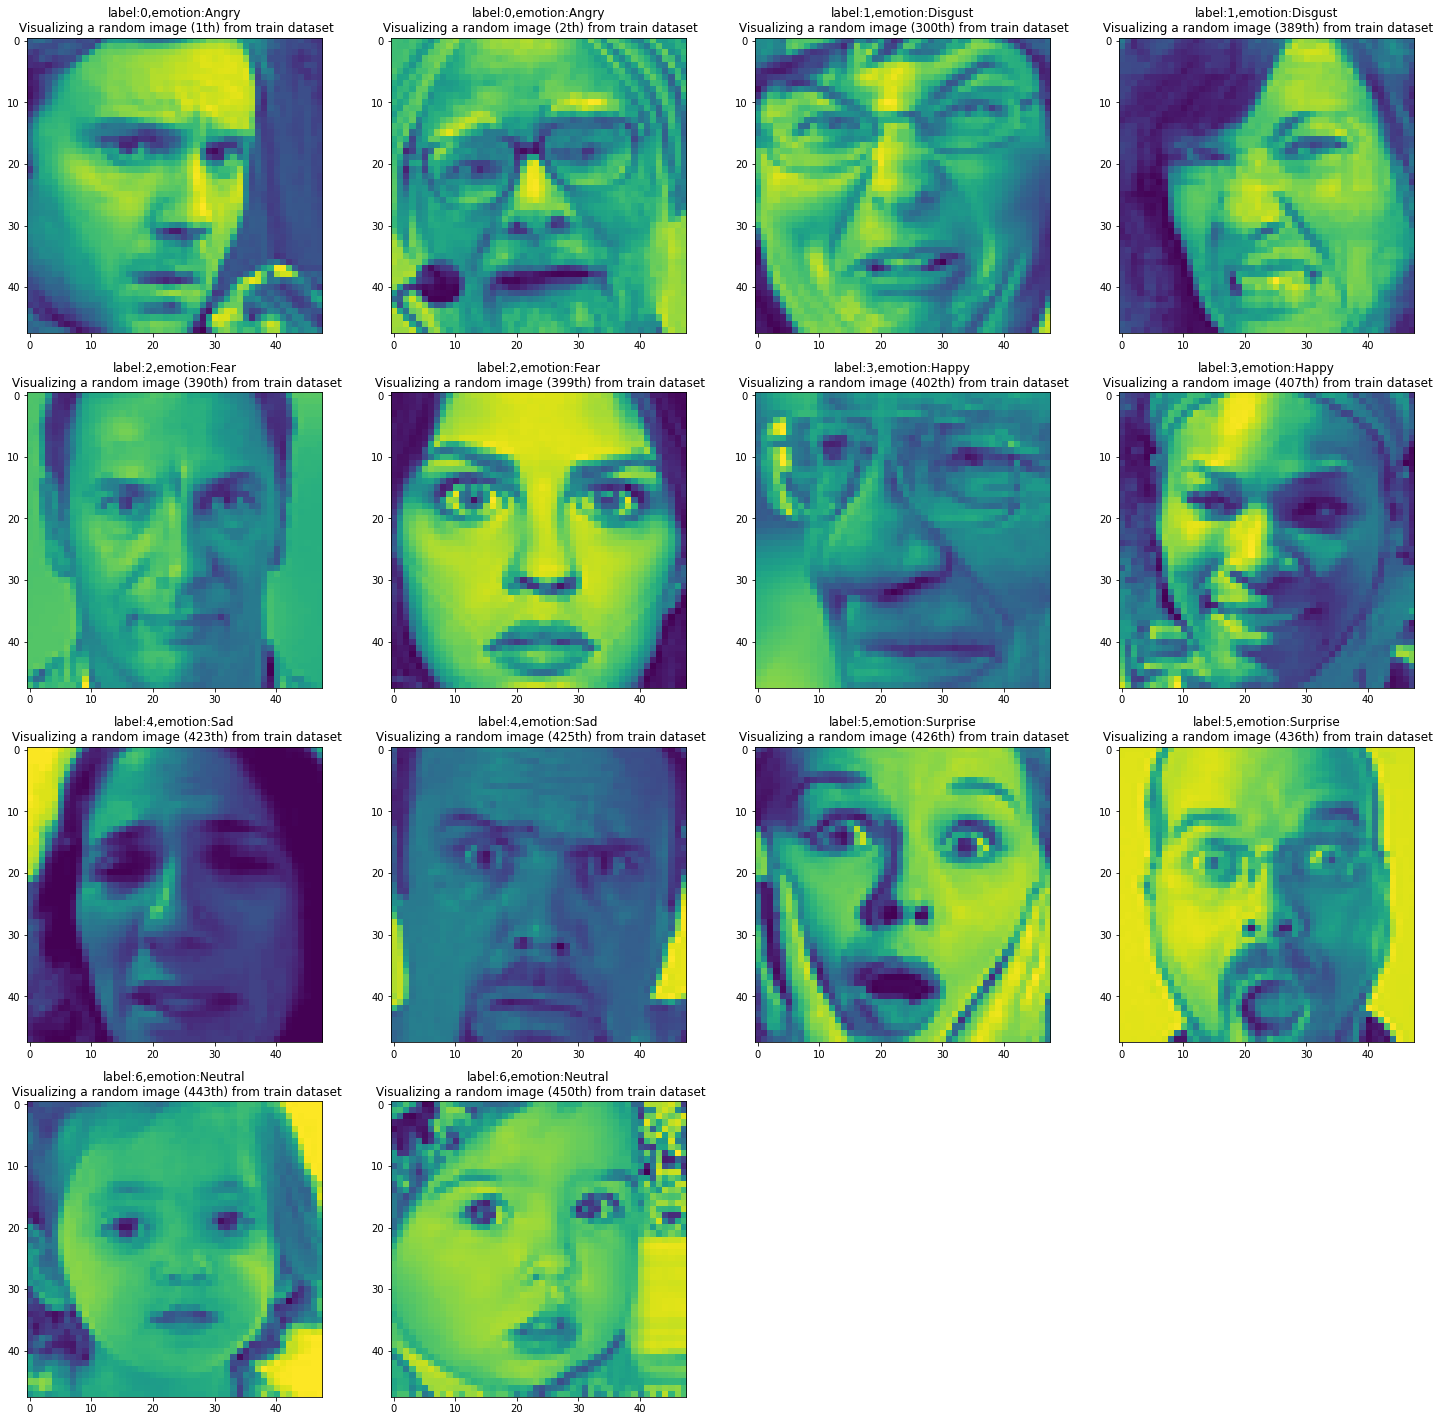

In [17]:
import warnings
warnings.filterwarnings("ignore")
#from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

labelMap = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

# Check number of samples (28709 in training, 3589 in valid and 3589 in test)
# Each image has 28 x 28 pixels
print("Train Image Shape: ", train_images.shape, "Train Label Shape: ", train_labels.shape)
print("Valid Image Shape: ", valid_images.shape, "Valid Label Shape: ", valid_labels.shape)  
print("Test Image Shape: ", test_images.shape, "Test Label Shape: ", test_labels.shape) 


def funcPlot(images_set,labels_set,dataName):
  fig = plt.figure(figsize=[25,25])
  index = 0
  plot_num = 0
  for i in range(len(images_set)):
    if labels_set[i] == index:
      a = fig.add_subplot(4,4,plot_num+1)
      _ = plt.imshow(images_set[i])
      a.set_title("label:{},emotion:{}\n Visualizing a random image ({}th) from {} dataset".format(
          labels_set[i],labelMap[labels_set[i]],i+1,dataName))
      plot_num +=1
      if plot_num%2 ==0:
        index +=1
    if index ==7:
      break
  plt.show()
funcPlot(train_images,train_labels,'train')

# 2(b)

In [18]:
num_emotion = []
for i in range(7):
  num_tep = np.count_nonzero(train_labels==i)
  num_emotion.append(num_tep)
  print(i,labelMap[i],num_tep)
print(len(train_labels),sum(num_emotion))

0 Angry 3995
1 Disgust 436
2 Fear 4097
3 Happy 7215
4 Sad 4830
5 Surprise 3171
6 Neutral 4965
28709 28709


# Data Preprocessing

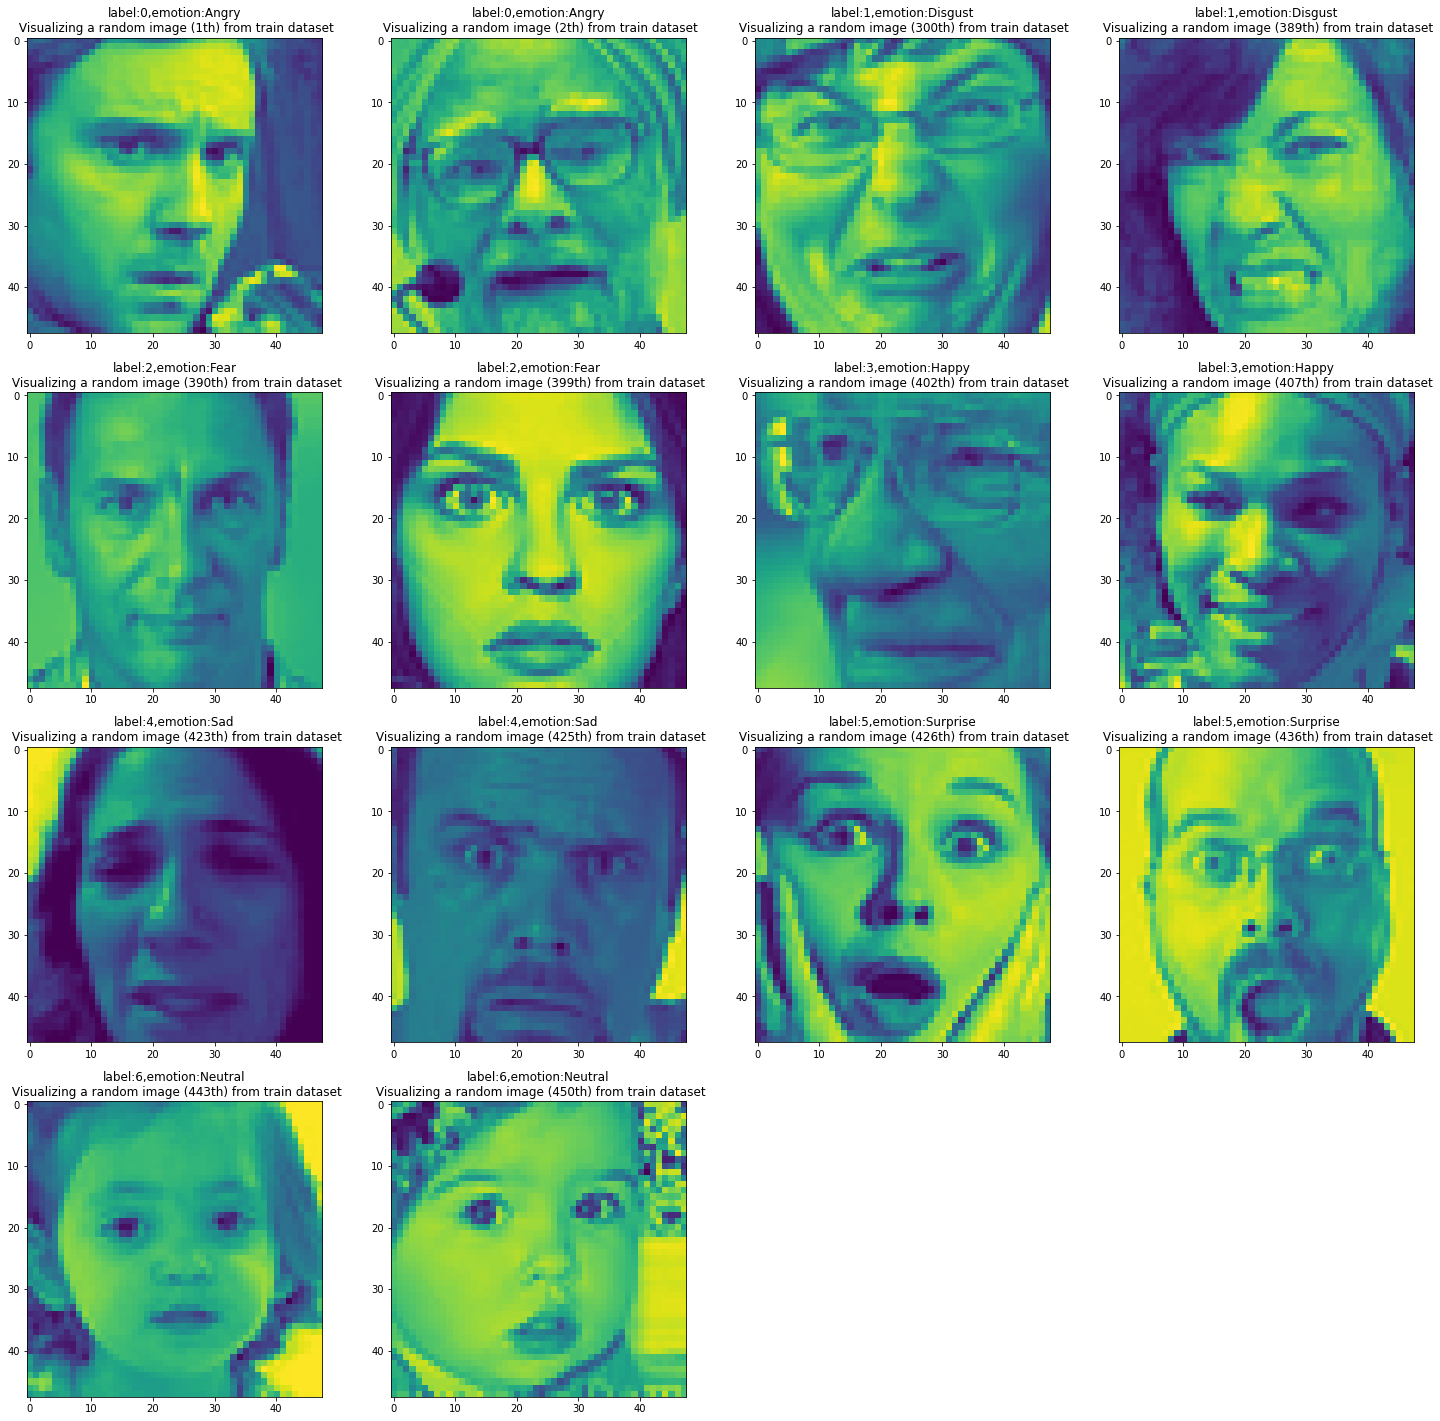

In [19]:
# tf.image.per_image_standardization
def np_per_image_standardization(ImageData):
  N = 48*48
  N = 1/np.sqrt(N)
  ImageData = np.array(ImageData,dtype=float)
  for i in range(len(ImageData)):
    mean = np.mean(ImageData[i])
    stddev = np.std(ImageData[i])
    adjusted_stddev = max(stddev,N)
    #image_tep = (ImageData[i] - mean)/adjusted_stddev
    #print(image_tep)
    ImageData[i] = (ImageData[i] - mean)/adjusted_stddev
    #print(ImageData[i])
  return ImageData

#print(np_per_image_standardization(train_images[0:2])[1])
train_image = np_per_image_standardization(train_images)
valid_image = np_per_image_standardization(valid_images)
test_image = np_per_image_standardization(test_images)
funcPlot(train_image,train_labels,'train')

# 2(c)

In [20]:
import warnings
warnings.filterwarnings("ignore")  # Ignore some warning logs
import time
from keras.optimizers import SGD

from keras.models import Sequential
from keras.layers import Dense, Dropout

# Flatten the images into vectors (1D) for feed forward network
flatten_train_images = train_image.reshape((-1, 48*48))
flatten_valid_images = valid_image.reshape((-1, 48*48))
flatten_test_images = test_image.reshape((-1, 48*48))
#print(train_labels)

def funcPlot_ce(train_acc,valid_acc,train_loss,valid_loss,
                num_layers,num_nodes,act_func,
                dropout_ratio,regulaize_ratio):
  x_aix = np.linspace(1,30,30)
  fig = plt.figure(figsize=(15,7))
  a = fig.add_subplot(1,2,1)
  plt.plot(x_aix,train_acc,'+-',x_aix,valid_acc,'o-')#,x_aix,test_acc,'+-')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['train','valid'])#,'test'])
  
  a = fig.add_subplot(1,2,2)
  plt.plot(x_aix,train_loss,'+-',x_aix,valid_loss,'o-')#,x_aix,test_loss,'+-')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train','valid'])#,'test'])
  plt.suptitle('layers number:{},nodes number:{},activation function:{},\n dropout ratio:{}, regulaization ratio:{}'.format(num_layers,
                                                                                                                            num_nodes,
                                                                                                                            act_func, 
                                                                                                                            dropout_ratio, 
                                                                                                                            regulaize_ratio))
  plt.show()
  plt.savefig("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_n{}_{}_d{}_r{}.png".format(num_layers,
                                                                                                          num_nodes,
                                                                                                          act_func, 
                                                                                                          int(dropout_ratio*10), 
                                                                                                          int(regulaize_ratio*1000)))
  
def funcFnn(num_layers,num_nodes,act_func, dropout_ratio, regulaize_ratio,train_status = True): 
  #num_layers = 2,3,4,5,6  or 2,3,4,5,6
  #num_does = 48*48                or 24*24
  #act_func = 'relu' or 'sigmoid' or 'tanh'
  #dropout_ratio = 0.1,0.2,0.3,0.4,0.5
  #regulaize_ratio = 0.001,0.01,0.1
  #  Define a Feed-Forward Model
  model = Sequential()
  nodes_tep = num_nodes
  for i in range(num_layers-1):
    if i != num_layers-2:
      model.add(Dense(nodes_tep, activation=act_func, input_shape=(48*48,), name="{}_hidden_layer".format(i+1)))  
      nodes_tep = nodes_tep//2
    else:
      if i == 0:#no drop out, layer number =2 
        model.add(Dense(nodes_tep, activation=act_func, input_shape=(48*48,), name="{}_hidden_layer".format(i+1)))
      else:
        model.add(Dropout(dropout_ratio))
  model.add(Dense(7, activation='softmax',name="{}_hidden_layer".format(num_layers)))
  
  #  Validate your Model Architecture
  print(model.summary())
  
  # Compile model
  opt = SGD(lr=0.01, momentum=0.9, decay=regulaize_ratio)
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'],)
  
  if train_status == True:
    # Train model
    time1 = time.time()
    training = model.fit(flatten_train_images, 
                         to_categorical(train_labels), 
                         epochs=30, 
                         batch_size=256,
                         validation_data=(flatten_valid_images,
                                          to_categorical(valid_labels)))
    time2 = time.time() -time1
    funcPlot_ce(training.history['accuracy'],training.history['val_accuracy'],
                training.history['loss'],training.history['val_loss'],
                num_layers,num_nodes,act_func,
                dropout_ratio,regulaize_ratio)
    return [training.history['accuracy'],training.history['val_accuracy']],time2,model.count_params()
  else:
    # Test model
      training = model.fit(np.vstack([flatten_train_images,
                                      flatten_valid_images]),
                           to_categorical(np.hstack([train_labels,
                                                     valid_labels])), 
                           epochs=30, 
                           batch_size=256,
                           )
      performance = model.evaluate(flatten_test_images, to_categorical(test_labels))
      return performance 
import pickle
act_func_Map = {0:'relu',1:'sigmoid',2:'tanh'}
regulaize_ratio = [0.001,0.01]
dropout_ratio = [0.2,0.3,0.4]
num_layers1= [2,3,4,5,6] #48*48
num_nodes = [48*48,48*48//2,24*24]
#num_layers2 = [2,3,4,5,6]    #24*24

In [21]:
performance =funcFnn(4,2304,'relu',0.3, 0.001,train_status=False)
#2304 ['relu', 0.001, 0.3, 4]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
2_hidden_layer (Dense)       (None, 1152)              2655360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1152)              0         
_________________________________________________________________
4_hidden_layer (Dense)       (None, 7)                 8071      
Total params: 7,974,151
Trainable params: 7,974,151
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
127/127 [==============================] - 1s 6ms/step - loss: 1.6924 - accuracy: 0.3416
Epoch 2/30
127/127 [==============================] - 1s 6ms/step - loss: 1.4657 - accuracy: 0.4400
Epoch 3/30
127/127 [=================

In [9]:
print(performance)

[1.8752832412719727, 0.4831429421901703]


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
2_hidden_layer (Dense)       (None, 7)                 16135     
Total params: 5,326,855
Trainable params: 5,326,855
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
113/113 [==============================] - 1s 7ms/step - loss: 1.7707 - accuracy: 0.3357 - val_loss: 1.7044 - val_accuracy: 0.3408
Epoch 2/30
113/113 [==============================] - 1s 5ms/step - loss: 1.4479 - accuracy: 0.4511 - val_loss: 1.5613 - val_accuracy: 0.3987
Epoch 3/30
113/113 [==============================] - 1s 5ms/step - loss: 1.2994 - accuracy: 0.5187 - val_loss: 1.5935 - val_accuracy: 0.3979
Epoch 4/30
113/113 [==============================] - 1s 5ms/step - loss: 

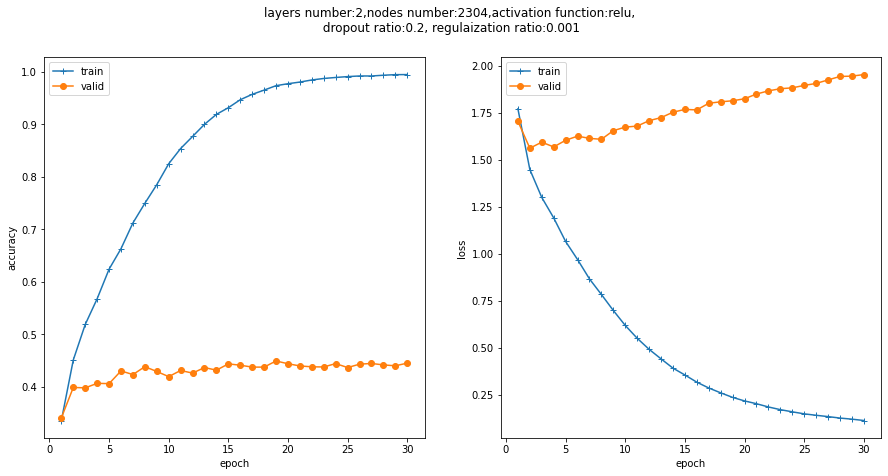

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
dropout_34 (Dropout)         (None, 2304)              0         
_________________________________________________________________
3_hidden_layer (Dense)       (None, 7)                 16135     
Total params: 5,326,855
Trainable params: 5,326,855
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
113/113 [==============================] - 1s 6ms/step - loss: 1.8009 - accuracy: 0.3276 - val_loss: 1.6428 - val_accuracy: 0.3617
Epoch 2/30
113/113 [==============================] - 1s 5ms/step - loss: 1.5041 - accuracy: 0.4278 - val_loss: 1.5809 - val_accuracy: 0.3962
Epoch 3/30
113/113 [==============================] - 1s 5ms/step - loss: 1.3906 - a

<Figure size 432x288 with 0 Axes>

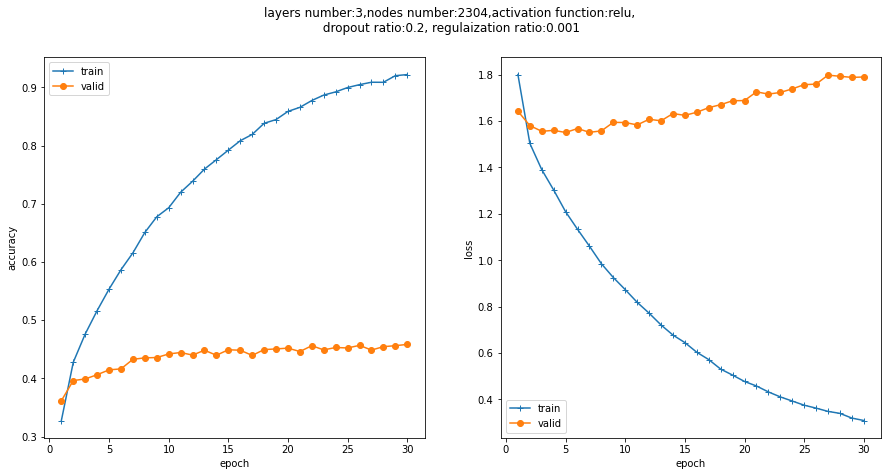

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
2_hidden_layer (Dense)       (None, 1152)              2655360   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1152)              0         
_________________________________________________________________
4_hidden_layer (Dense)       (None, 7)                 8071      
Total params: 7,974,151
Trainable params: 7,974,151
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
113/113 [==============================] - 1s 7ms/step - loss: 1.6915 - accuracy: 0.3404 - val_loss: 1.5861 - val_accuracy: 0.3734
Epoch 2/30
113/113 [==============================] - 1s 6ms/step - loss: 1.4463 - accuracy: 0

<Figure size 432x288 with 0 Axes>

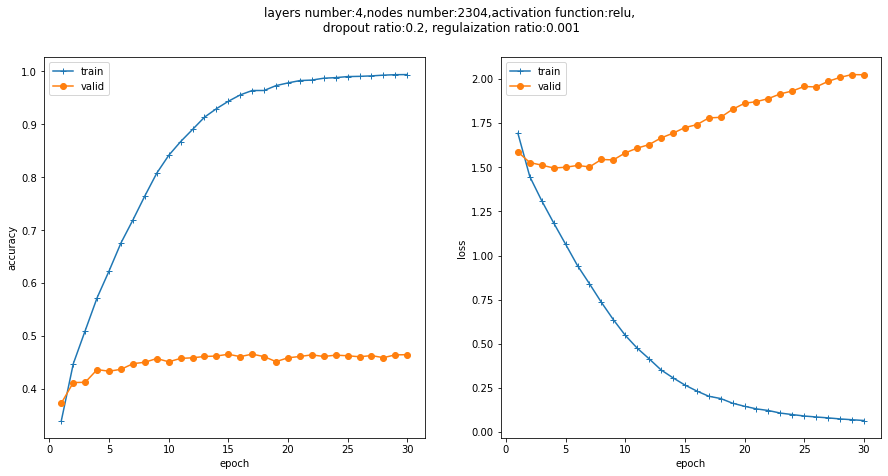

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
2_hidden_layer (Dense)       (None, 1152)              2655360   
_________________________________________________________________
3_hidden_layer (Dense)       (None, 576)               664128    
_________________________________________________________________
dropout_36 (Dropout)         (None, 576)               0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 7)                 4039      
Total params: 8,634,247
Trainable params: 8,634,247
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
113/113 [==============================] - 1s 10ms/step - loss: 1.6856 - accuracy: 0.3336 - v

<Figure size 432x288 with 0 Axes>

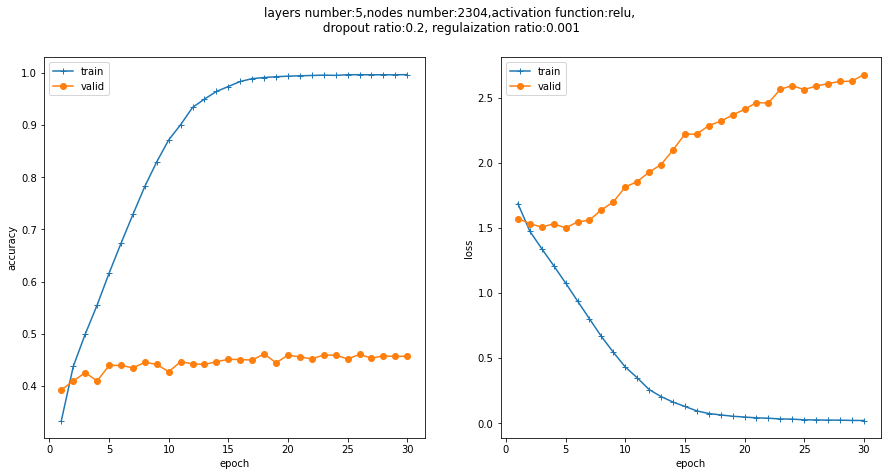

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
2_hidden_layer (Dense)       (None, 1152)              2655360   
_________________________________________________________________
3_hidden_layer (Dense)       (None, 576)               664128    
_________________________________________________________________
4_hidden_layer (Dense)       (None, 288)               166176    
_________________________________________________________________
dropout_37 (Dropout)         (None, 288)               0         
_________________________________________________________________
6_hidden_layer (Dense)       (None, 7)                 2023      
Total params: 8,798,407
Trainable params: 8,798,407
Non-trainable params: 0
___________________________________________

<Figure size 432x288 with 0 Axes>

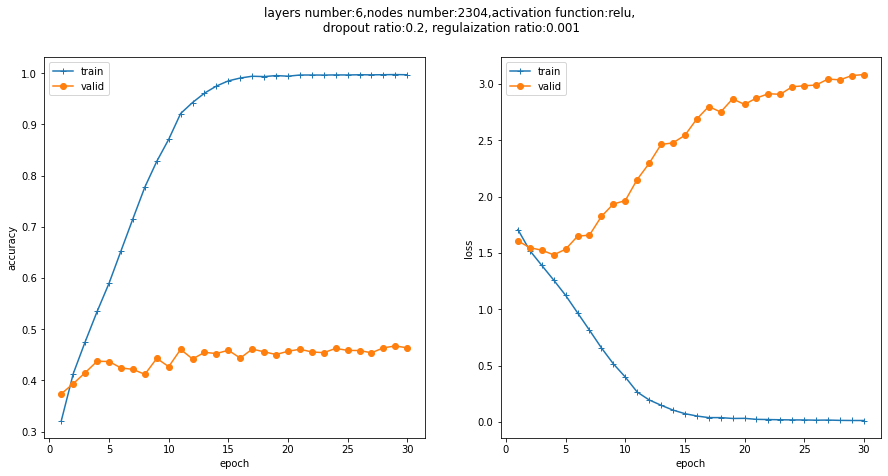

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
2_hidden_layer (Dense)       (None, 7)                 16135     
Total params: 5,326,855
Trainable params: 5,326,855
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
113/113 [==============================] - 1s 6ms/step - loss: 1.7438 - accuracy: 0.3413 - val_loss: 1.6503 - val_accuracy: 0.3820
Epoch 2/30
113/113 [==============================] - 1s 5ms/step - loss: 1.4554 - accuracy: 0.4468 - val_loss: 1.5751 - val_accuracy: 0.4023
Epoch 3/30
113/113 [==============================] - 1s 5ms/step - loss: 1.3098 - accuracy: 0.5099 - val_loss: 1.5508 - val_accuracy: 0.4185
Epoch 4/30
113/113 [==============================] - 1s 5ms/step - loss: 

<Figure size 432x288 with 0 Axes>

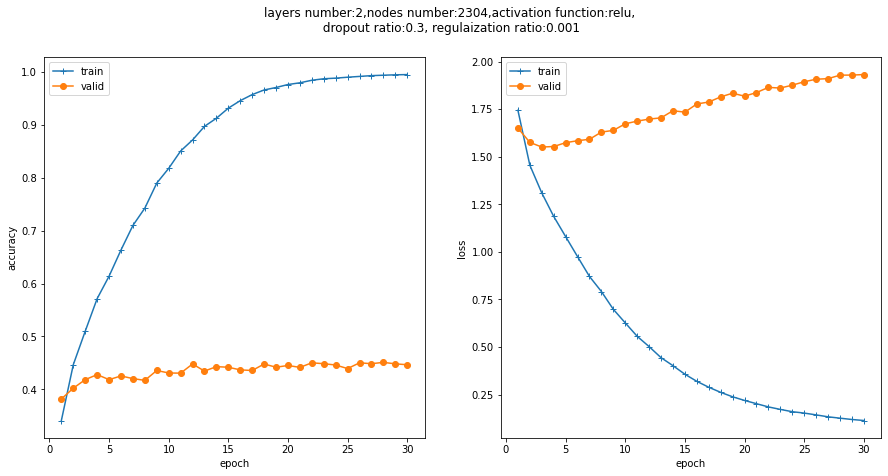

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Dense)       (None, 2304)              5310720   
_________________________________________________________________
dropout_38 (Dropout)         (None, 2304)              0         
_________________________________________________________________
3_hidden_layer (Dense)       (None, 7)                 16135     
Total params: 5,326,855
Trainable params: 5,326,855
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
113/113 [==============================] - 1s 6ms/step - loss: 1.8412 - accuracy: 0.3222 - val_loss: 1.6307 - val_accuracy: 0.3728
Epoch 2/30
113/113 [==============================] - 1s 5ms/step - loss: 1.5275 - accuracy: 0.4191 - val_loss: 1.5745 - val_accuracy: 0.3945
Epoch 3/30
113/113 [==============================] - 1s 5ms/step - loss: 1.4221 - a

In [ ]:
history10=[]
time10=[]
model_parmeter10 = []
hyper_parameter10 = []
#for ind_af in range(3):
  #af = act_func_Map[ind_af]
af = act_func_Map[0]
for ind_nd in num_nodes:
  for ind_rr in regulaize_ratio:
    for ind_dr in dropout_ratio:
      for ind_ny1 in num_layers1:
        history_tep,time_tep,model_tep=funcFnn(ind_ny1,ind_nd,af,ind_dr, ind_rr)
        history10.append(history_tep)
        time10.append(time_tep)
        model_parmeter10.append(model_tep)
        hyper_parameter10.append([af,ind_rr,ind_dr,ind_ny1])

        l = [history_tep,time_tep,model_tep]
        with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_n{}_a{}_d{}_r{}.txt".format(ind_ny1,
                                                                                                            ind_nd,
                                                                                                            af, 
                                                                                                            int(ind_dr*10), 
                                                                                                            int(ind_rr*1000)), "wb") as fp:   #Pickling
          pickle.dump(l, fp)

with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_acc.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(history10, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_time.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(time10, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_number.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(model_parmeter10, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_paraSetting.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(hyper_parameter10, fp)

In [ ]:
history11=[]
time11=[]
model_parmeter11 = []
hyper_parameter11 = []
#for ind_af in range(3):
  #af = act_func_Map[ind_af]
af = act_func_Map[1]
for ind_nd in num_nodes:
  for ind_rr in regulaize_ratio:
    for ind_dr in dropout_ratio:
      for ind_ny1 in num_layers1:
        history_tep,time_tep,model_tep=funcFnn(ind_ny1,ind_nd,af,ind_dr, ind_rr)
        history11.append(history_tep)
        time11.append(time_tep)
        model_parmeter11.append(model_tep)
        hyper_parameter11.append([af,ind_rr,ind_dr,ind_ny1])

        l = [history_tep,time_tep,model_tep]
        with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_n{}_a{}_d{}_r{}.txt".format(ind_ny1,
                                                                                                            ind_nd,
                                                                                                            af, 
                                                                                                            int(ind_dr*10), 
                                                                                                            int(ind_rr*1000)), "wb") as fp:   #Pickling
          pickle.dump(l, fp)

with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_acc.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(history11, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_time.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(time11, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_number.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(model_parmeter11, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_paraSetting.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(hyper_parameter11, fp)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
history12=[]
time12=[]
model_parmeter12 = []
hyper_parameter12 = []
#for ind_af in range(3):
  #af = act_func_Map[ind_af]
af = act_func_Map[2]
for ind_nd in num_nodes:
  for ind_rr in regulaize_ratio:
    for ind_dr in dropout_ratio:
      for ind_ny1 in num_layers1:
        history_tep,time_tep,model_tep=funcFnn(ind_ny1,ind_nd,af,ind_dr, ind_rr)
        history12.append(history_tep)
        time12.append(time_tep)
        model_parmeter12.append(model_tep)
        hyper_parameter12.append([af,ind_rr,ind_dr,ind_ny1])

        l = [history_tep,time_tep,model_tep]
        with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_n{}_a{}_d{}_r{}.txt".format(ind_ny1,
                                                                                                            ind_nd,
                                                                                                            af, 
                                                                                                            int(ind_dr*10), 
                                                                                                            int(ind_rr*1000)), "wb") as fp:   #Pickling
          pickle.dump(l, fp)

with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_acc.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(history12, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_time.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(time12, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_number.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(model_parmeter12, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/fnn_{}_paraSetting.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(hyper_parameter12, fp)

# 2(d)

In [22]:
import warnings
warnings.filterwarnings("ignore")  # Ignore some warning logs
import time

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, Flatten, MaxPooling2D
from keras.optimizers import SGD


train_images_3d = train_image.reshape(-1,48,48,1)
valid_images_3d = valid_image.reshape(-1,48,48,1)
test_images_3d = test_image.reshape(-1,48,48,1)
#print(train_labels)

def funcPlot_ce_3d(train_acc,valid_acc,train_loss,valid_loss,
                num_layers,filter_size,stride_size,act_func,
                dropout_ratio,regulaize_ratio):
  x_aix = np.linspace(1,30,30)
  fig = plt.figure(figsize=(15,7))
  a = fig.add_subplot(1,2,1)
  plt.plot(x_aix,train_acc,'+-',x_aix,valid_acc,'o-')#,x_aix,test_acc,'+-')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['train','valid'])#,'test'])
  
  a = fig.add_subplot(1,2,2)
  plt.plot(x_aix,train_loss,'+-',x_aix,valid_loss,'o-')#,x_aix,test_loss,'+-')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train','valid'])#,'test'])
  plt.suptitle('layers number:{},filter_size:{},stride_size:{},\n activation function:{}, dropout ratio:{}, regulaization ratio:{}'.format(num_layers,
                                                                                                                            filter_size,
                                                                                                                            stride_size,
                                                                                                                            act_func, 
                                                                                                                            dropout_ratio, 
                                                                                                                            regulaize_ratio))
  plt.show()
  plt.savefig("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_f{}_s{}_{}_d{}_r{}.png".format(num_layers,
                                                                                                            filter_size,
                                                                                                            stride_size,
                                                                                                            act_func, 
                                                                                                            int(dropout_ratio*10), 
                                                                                                            int(regulaize_ratio*1000)))

def funcCnn(num_layers,filter_size,stride_size,act_func, dropout_ratio, regulaize_ratio,train_status = True): 
  #num_layers =  4+ 3,6,9,12  or 4+ 3
  #stride_size = 1               or 2
  #filter_size = 3 or 5
  #act_func = 'relu' or 'sigmoid' or 'tanh'
  #dropout_ratio = 0.1,0.2,0.3,0.4,0.5
  #regulaize_ratio = 0.001,0.01,0.1
  #  Define a Feed-Forward Model
  model = Sequential()
  nodes_tep = 32
  for i in range((num_layers-4)//3):
    if i==0:
      model.add(Conv2D(nodes_tep,
                       kernel_size = filter_size, 
                       activation=act_func, 
                       input_shape=(48,48,1), 
                       strides=(stride_size,stride_size),
                       padding = 'same',
                       name="{}_hidden_layer".format(i*3+1)))  
      model.add(Conv2D(nodes_tep, 
                       kernel_size = filter_size, 
                       activation=act_func,
                       strides=(stride_size,stride_size),
                       padding='same',
                       name="{}_hidden_layer".format(i*3+2)))
      model.add(MaxPooling2D(pool_size=(2,2)))
      nodes_tep = nodes_tep*2
    else:
      model.add(Conv2D(nodes_tep,
                       kernel_size = filter_size, 
                       activation=act_func,
                       strides=(stride_size,stride_size),  
                       padding = 'same',
                       name="{}_hidden_layer".format(i*3+1)))  
      model.add(Conv2D(nodes_tep, 
                       kernel_size = filter_size, 
                       activation=act_func,
                       strides=(stride_size,stride_size),
                       padding='same',
                       name="{}_hidden_layer".format(i*3+2)))
      model.add(MaxPooling2D(pool_size=(2,2)))
      nodes_tep = nodes_tep*2      
  model.add(Flatten())
  model.add(Dense(512, activation=act_func,name="{}_hidden_layer".format(num_layers-2))) 
  model.add(Dropout(dropout_ratio))
  model.add(Dense(7, activation='softmax',name="{}_hidden_layer".format(num_layers)))
  #  Validate your Model Architecture
  print(model.summary())
  
  # Compile model
  opt = SGD(lr=0.01, momentum=0.9, decay=regulaize_ratio)
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'],)
  
  if train_status == True:
    # Train model
    time1 = time.time()
    training = model.fit(train_images_3d, 
                         to_categorical(train_labels), 
                         epochs=30, 
                         batch_size=256,
                         validation_data=(valid_images_3d,
                                          to_categorical(valid_labels)))
    time2 = time.time() -time1
    funcPlot_ce_3d(training.history['accuracy'],training.history['val_accuracy'],
                training.history['loss'],training.history['val_loss'],
                num_layers,filter_size,stride_size,act_func,
                dropout_ratio,regulaize_ratio)
    return [training.history['accuracy'],training.history['val_accuracy']],time2,model.count_params()
  else:
    # Test model
      training = model.fit(np.vstack([train_images_3d,
                                      valid_images_3d]),
                           to_categorical(np.hstack([train_labels,
                                                     valid_labels])), 
                           epochs=30, 
                           batch_size=256,
                           )
      performance = model.evaluate(test_images_3d , to_categorical(test_labels))
      return performance 

import pickle
act_func_Map = {0:'relu',1:'sigmoid',2:'tanh'}
regulaize_ratio = [0.001,0.01]
dropout_ratio = [0.2,0.3,0.4]
num_layers_3d1= [7,10]  #num_layers =  4+ 3,6  or 4+ 3
num_layers_3d2 = 7            #stride_size = 1               or 2
filter_size = [3,5]

In [23]:
#1 5 ['relu', 0.001, 0.3, 10]
performance =funcCnn(10,5,1,'relu',0.3, 0.001,train_status=False)
#(num_layers,filter_size,stride_size,act_func, dropout_ratio, regulaize_ratio,train_status = True)
#2304 ['relu', 0.001, 0.3, 4]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)             

In [24]:
print(performance)

[2.315934658050537, 0.5792700052261353]


Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_79 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)               

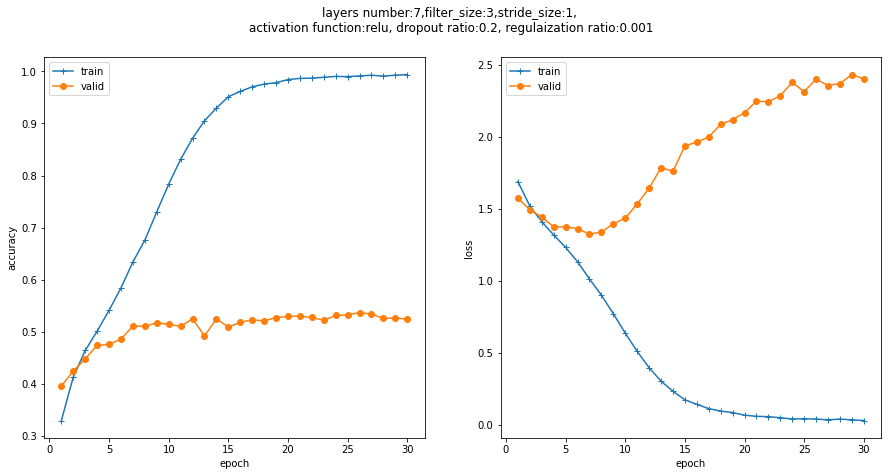

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        18496     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)           

<Figure size 432x288 with 0 Axes>

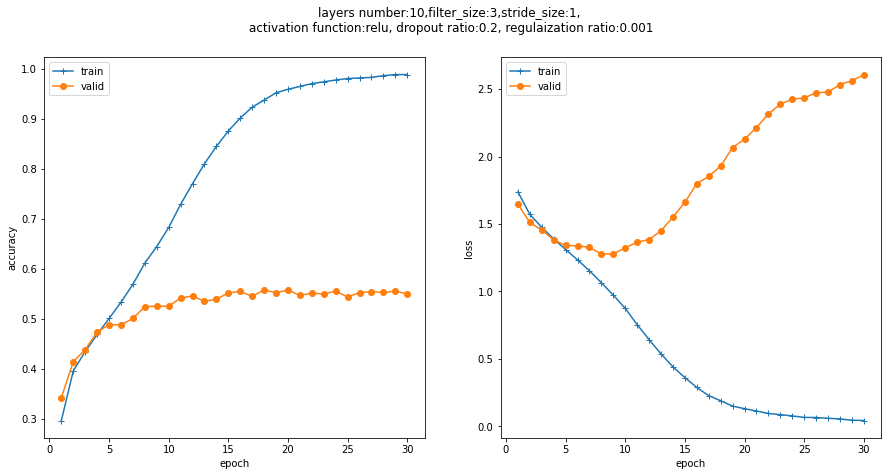

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_81 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

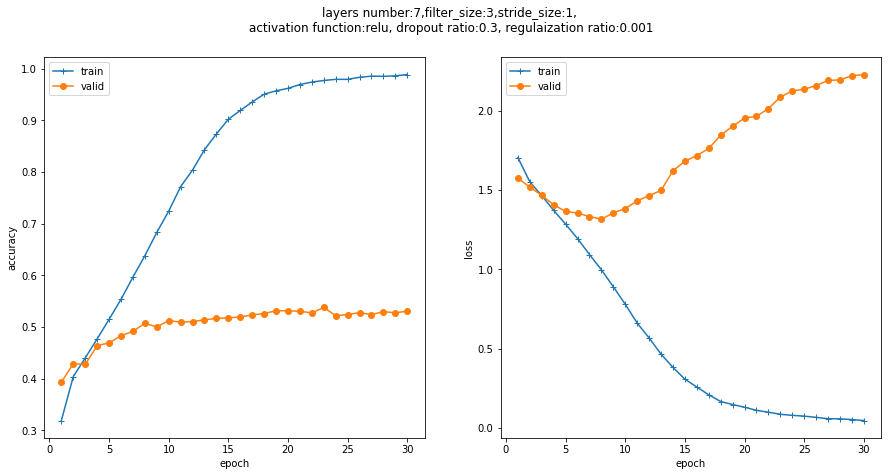

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        18496     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)           

<Figure size 432x288 with 0 Axes>

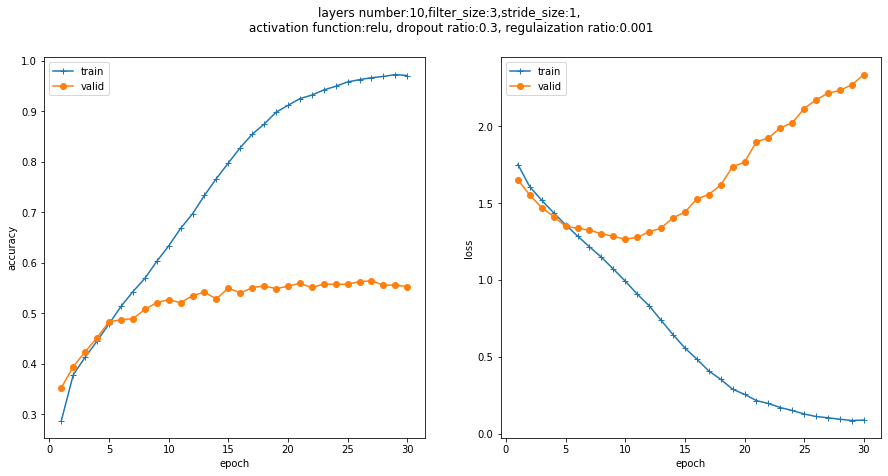

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_83 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

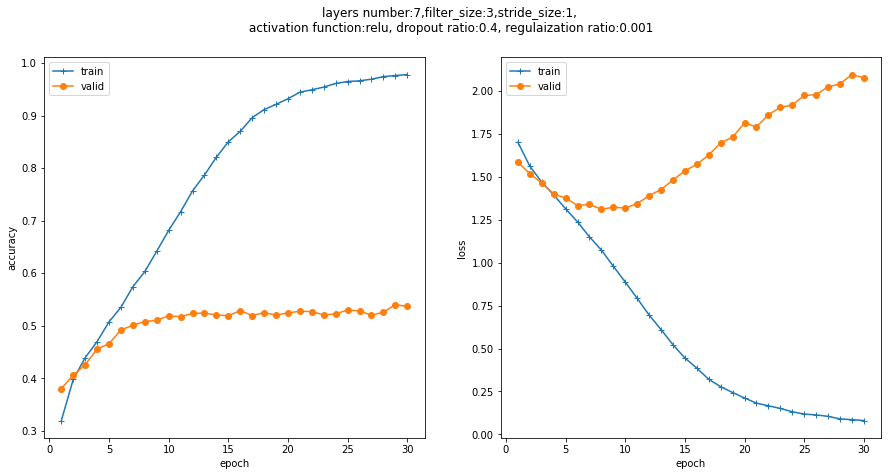

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        18496     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)           

<Figure size 432x288 with 0 Axes>

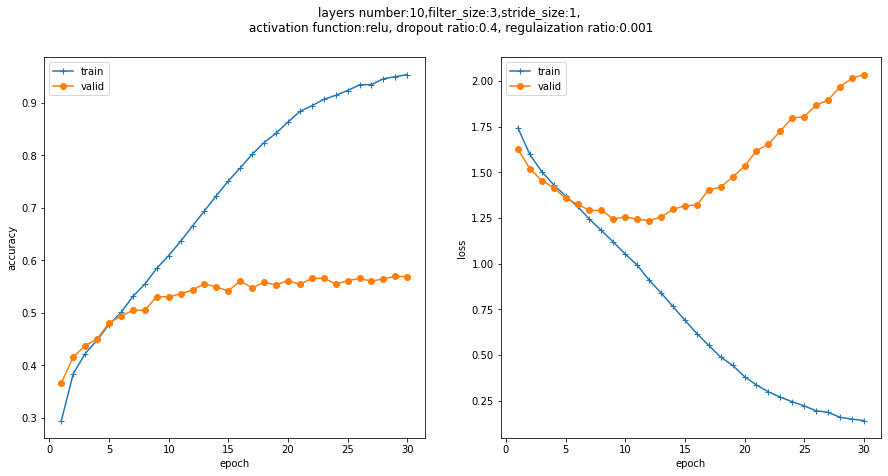

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_85 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

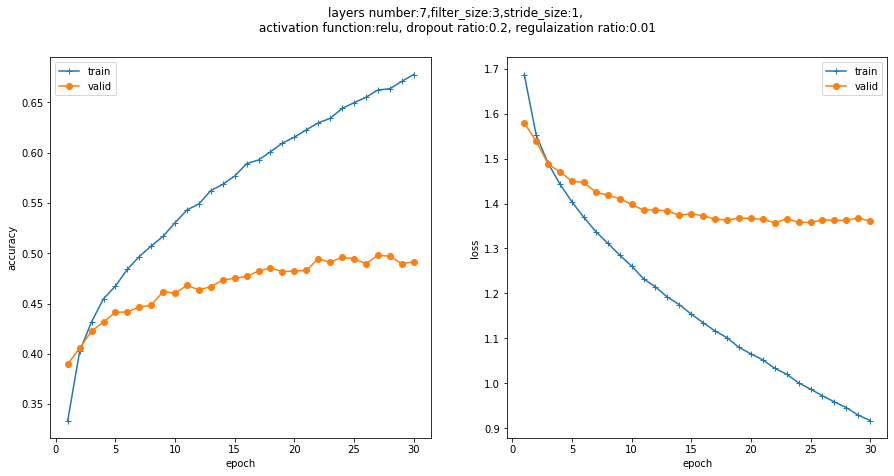

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        18496     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)           

<Figure size 432x288 with 0 Axes>

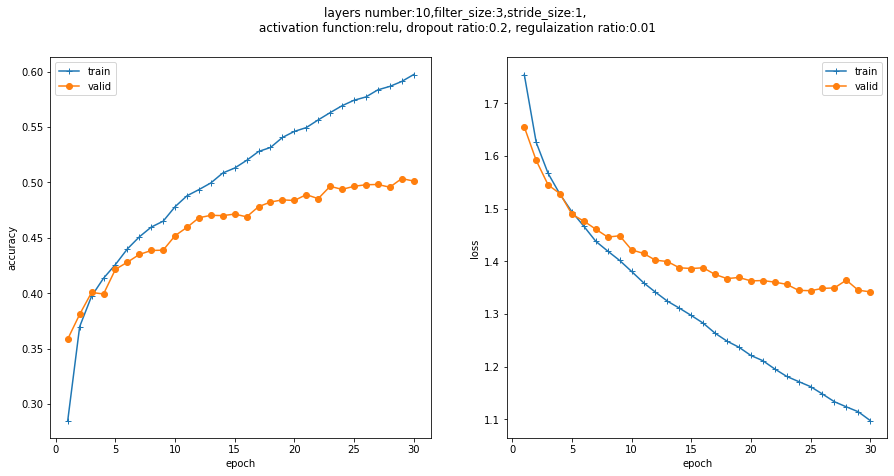

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_87 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

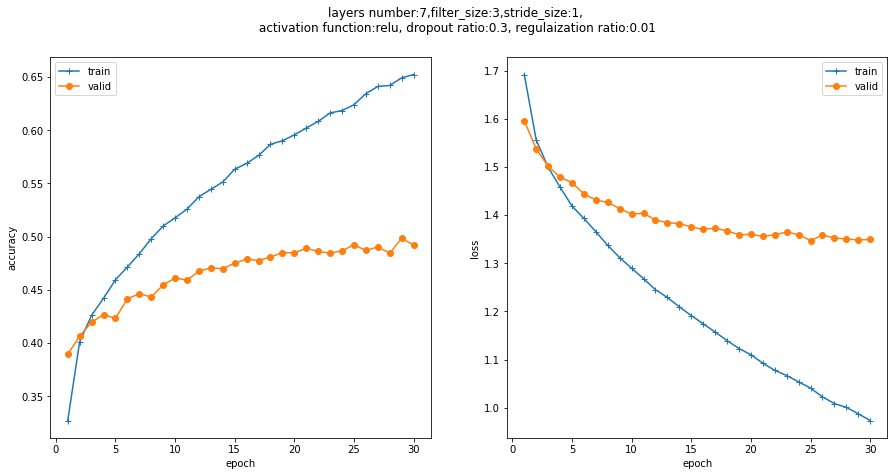

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        18496     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)           

<Figure size 432x288 with 0 Axes>

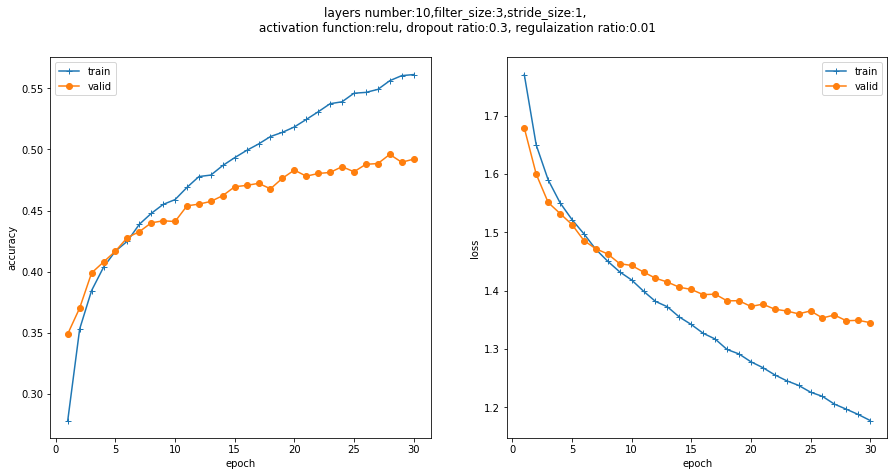

Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_89 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

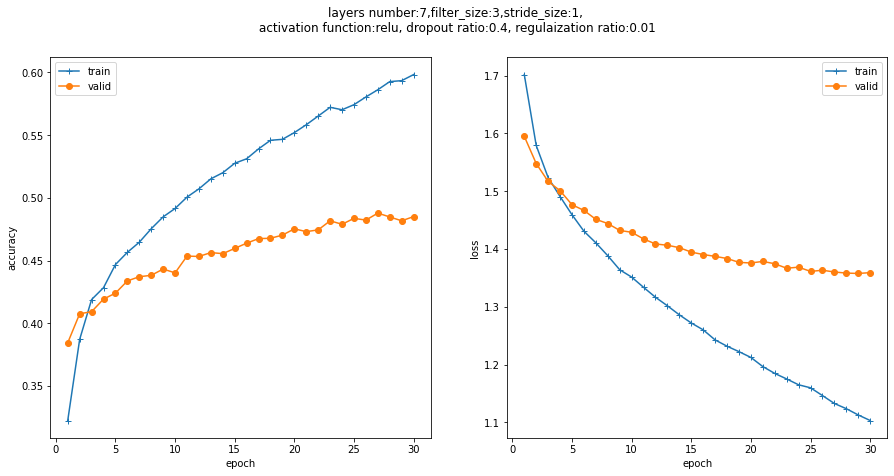

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        18496     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 9216)           

<Figure size 432x288 with 0 Axes>

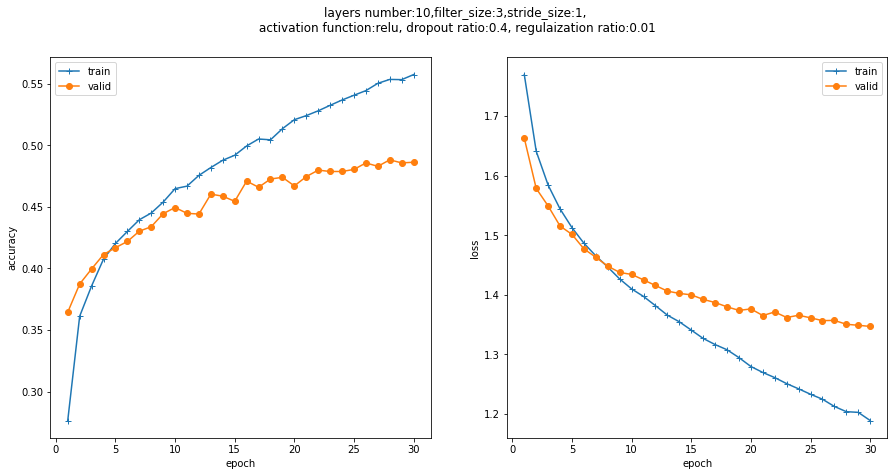

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_91 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

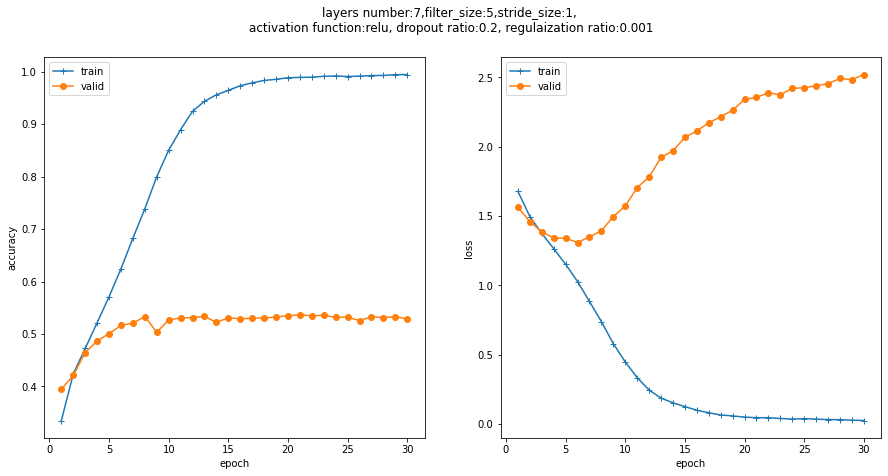

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 9216)           

<Figure size 432x288 with 0 Axes>

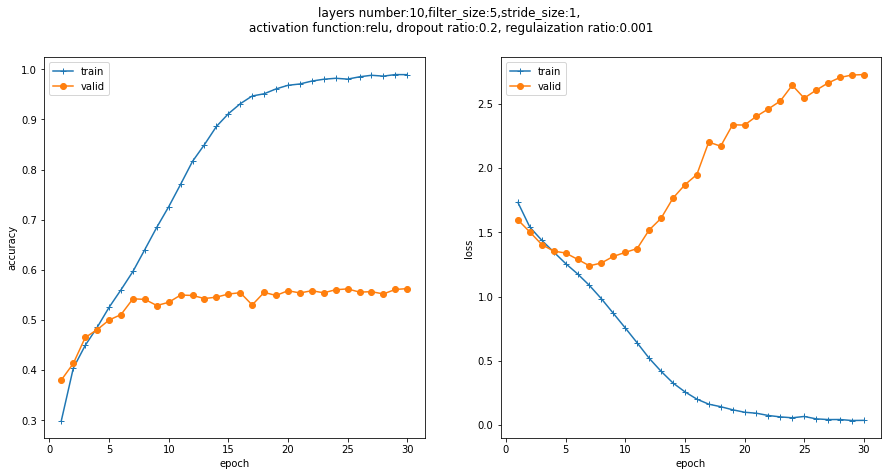

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_93 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

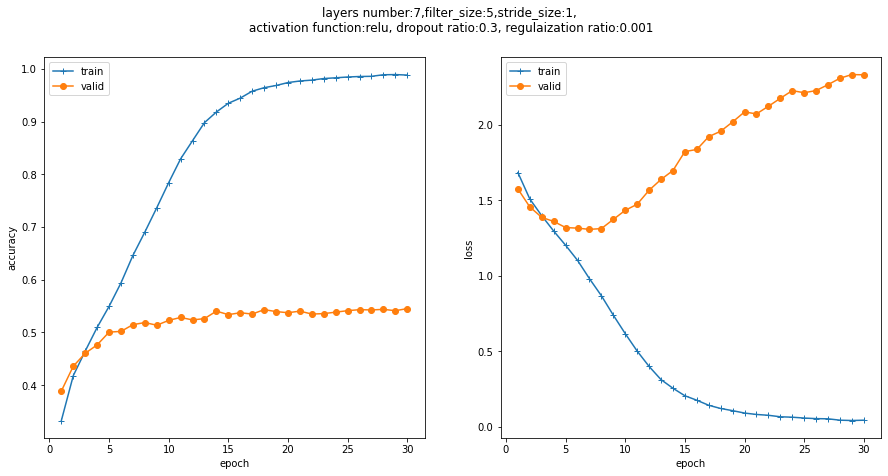

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 9216)           

<Figure size 432x288 with 0 Axes>

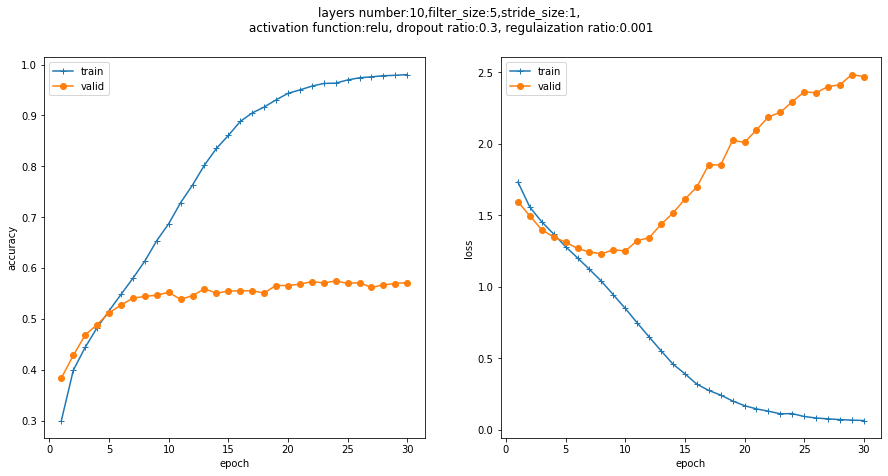

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_95 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

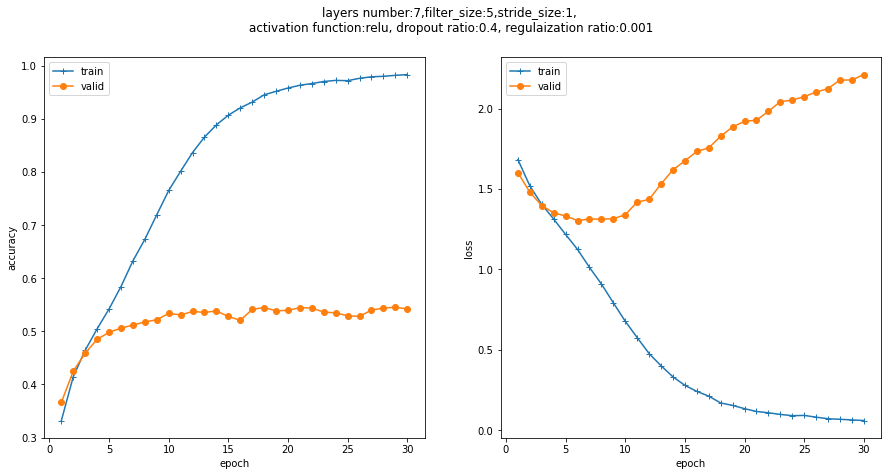

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 9216)           

<Figure size 432x288 with 0 Axes>

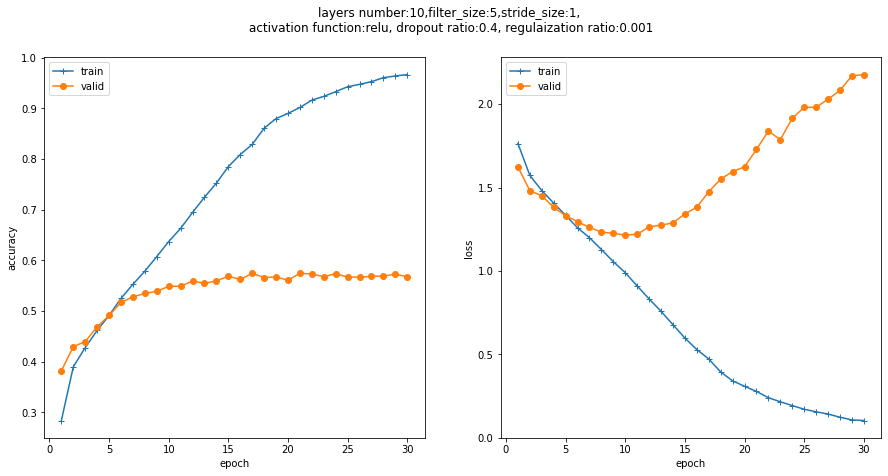

Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_97 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

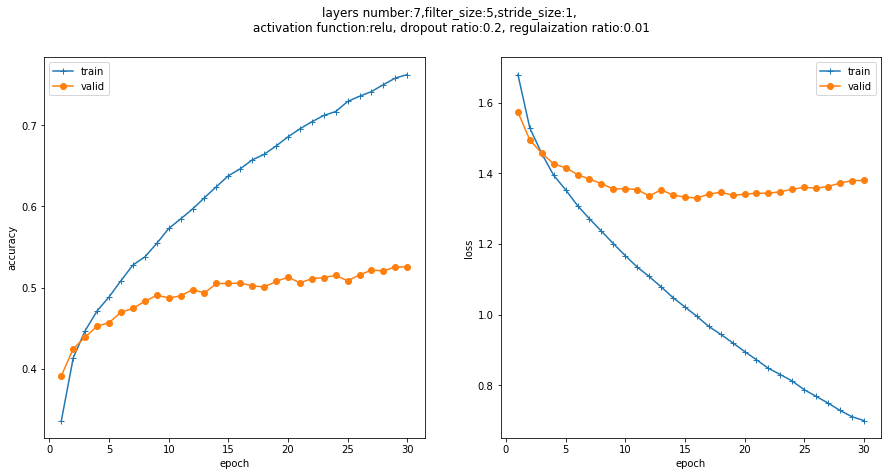

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 9216)           

<Figure size 432x288 with 0 Axes>

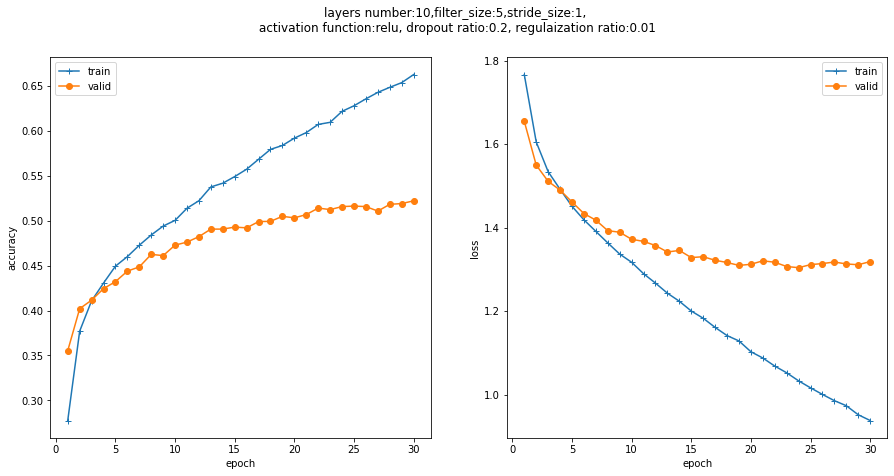

Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_99 (Dropout)         (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

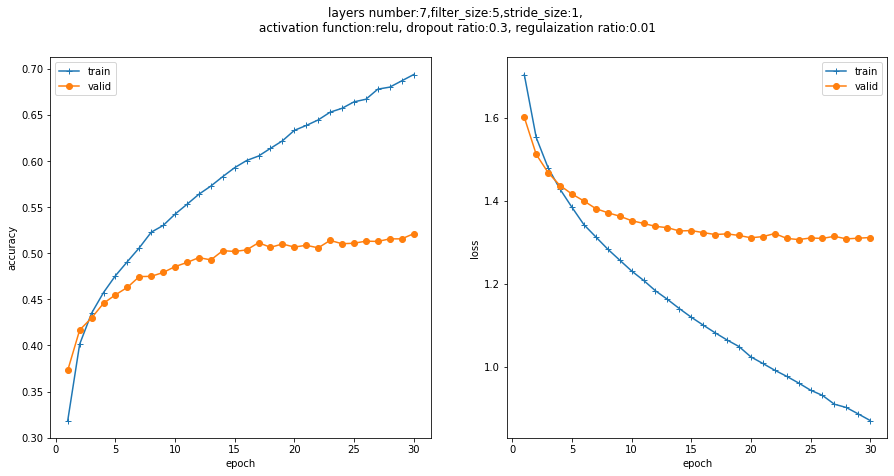

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 9216)           

<Figure size 432x288 with 0 Axes>

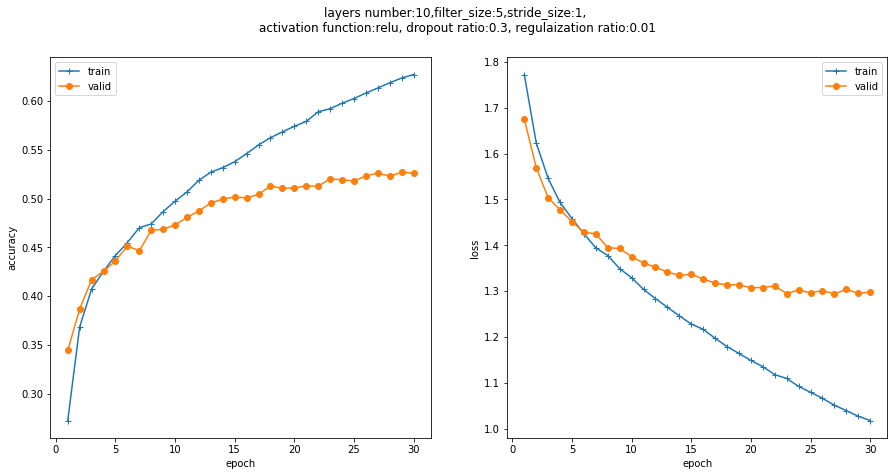

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_101 (Dropout)        (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

<Figure size 432x288 with 0 Axes>

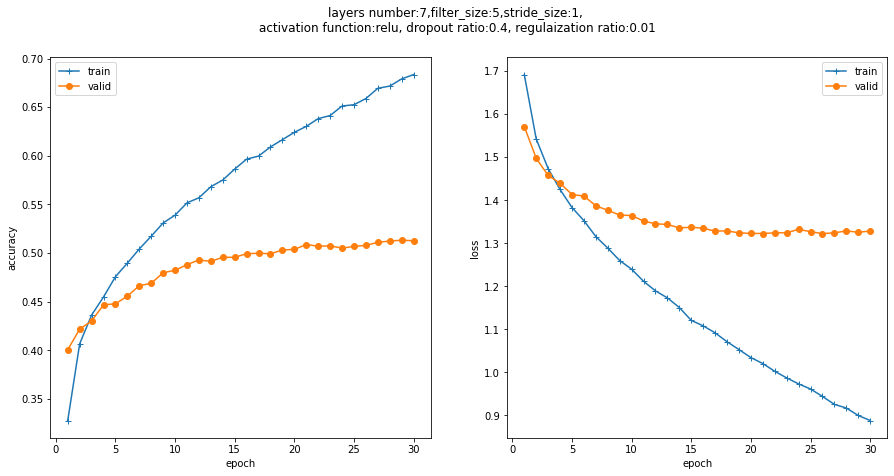

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 9216)           

<Figure size 432x288 with 0 Axes>

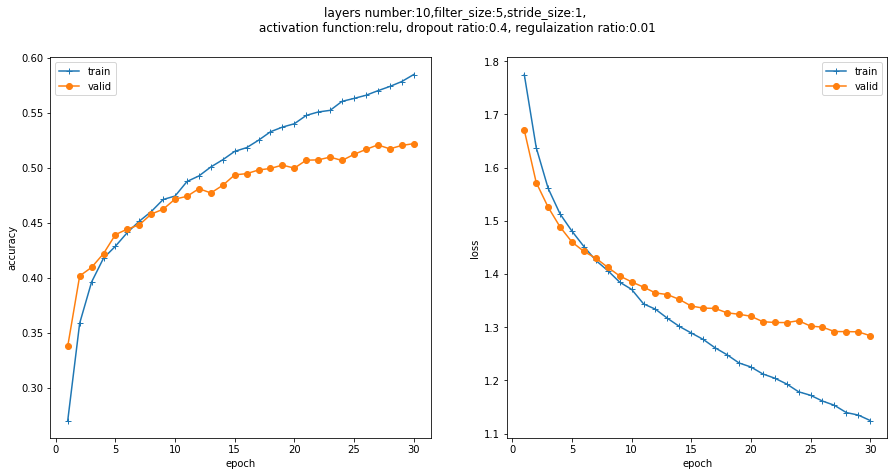

<Figure size 432x288 with 0 Axes>

In [ ]:
history_3d10=[]
time_3d10=[]
model_parmeter_3d10 = []
hyper_parameter_3d10 = []
#for ind_af in range(3):
  #af = act_func_Map[ind_af]
af = act_func_Map[0]
for ind_fs in filter_size:
  for ind_rr in regulaize_ratio:
    for ind_dr in dropout_ratio:
      for ind_ny1 in num_layers_3d1:
        history_tep,time_tep,model_tep=funcCnn(ind_ny1,ind_fs,1,af,ind_dr, ind_rr)
        history_3d10.append(history_tep)
        time_3d10.append(time_tep)
        model_parmeter_3d10.append(model_tep)
        hyper_parameter_3d10.append([af,ind_rr,ind_dr,ind_ny1])

        l = [history_tep,time_tep,model_tep]
        with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_f{}_s{}_a{}_d{}_r{}.txt".format(ind_ny1,
                                                                                                            ind_fs,
                                                                                                            1,
                                                                                                            af, 
                                                                                                            int(ind_dr*10), 
                                                                                                            int(ind_rr*1000)), "wb") as fp:   #Pickling
          pickle.dump(l, fp)

with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_acc.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(history_3d10, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_time.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(time_3d10, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_number.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(model_parmeter_3d10, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_paraSetting.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(hyper_parameter_3d10, fp)

In [ ]:
history_3d11=[]
time_3d11=[]
model_parmeter_3d11 = []
hyper_parameter_3d11 = []
#for ind_af in range(3):
  #af = act_func_Map[ind_af]
af = act_func_Map[1]
for ind_fs in filter_size:
  for ind_rr in regulaize_ratio:
    for ind_dr in dropout_ratio:
      for ind_ny1 in num_layers_3d1:
        history_tep,time_tep,model_tep=funcCnn(ind_ny1,ind_fs,1,af,ind_dr, ind_rr)
        history_3d11.append(history_tep)
        time_3d11.append(time_tep)
        model_parmeter_3d11.append(model_tep)
        hyper_parameter_3d11.append([af,ind_rr,ind_dr,ind_ny1])

        l = [history_tep,time_tep,model_tep]
        with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_f{}_s{}_a{}_d{}_r{}.txt".format(ind_ny1,
                                                                                                            ind_fs,
                                                                                                            1,
                                                                                                            af, 
                                                                                                            int(ind_dr*10), 
                                                                                                            int(ind_rr*1000)), "wb") as fp:   #Pickling
          pickle.dump(l, fp)

with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_acc.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(history_3d11, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_time.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(time_3d11, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_number.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(model_parmeter_3d11, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_paraSetting.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(hyper_parameter_3d11, fp)

In [ ]:
history_3d12=[]
time_3d12=[]
model_parmeter_3d12 = []
hyper_parameter_3d12 = []
#for ind_af in range(3):
  #af = act_func_Map[ind_af]
af = act_func_Map[2]
for ind_fs in filter_size:
  for ind_rr in regulaize_ratio:
    for ind_dr in dropout_ratio:
      for ind_ny1 in num_layers_3d1:
        history_tep,time_tep,model_tep=funcCnn(ind_ny1,ind_fs,1,af,ind_dr, ind_rr)
        history_3d12.append(history_tep)
        time_3d12.append(time_tep)
        model_parmeter_3d12.append(model_tep)
        hyper_parameter_3d12.append([af,ind_rr,ind_dr,ind_ny1])
        l = [history_tep,time_tep,model_tep]
        with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_f{}_s{}_a{}_d{}_r{}.txt".format(ind_ny1,
                                                                                                            ind_fs,
                                                                                                            1,
                                                                                                            af, 
                                                                                                            int(ind_dr*10), 
                                                                                                            int(ind_rr*1000)), "wb") as fp:   #Pickling
          pickle.dump(l, fp)

with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_acc.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(history_3d12, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_time.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(time_3d12, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_number.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(model_parmeter_3d12, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid1_{}_paraSetting.txt".format(af), "wb") as fp:   #Pickling
  pickle.dump(hyper_parameter_3d12, fp)

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_103 (Dropout)        (None, 512)               0         
_________________________________________________________________
7_hidden_layer (Dense)       (None, 7)              

KeyboardInterrupt: ignored

In [ ]:
history_3d2=[]
time_3d2=[]
model_parmeter_3d2 = []
hyper_parameter_3d2 = []
for ind_af in range(3):
  af = act_func_Map[ind_af]
  for ind_fs in filter_size:
    for ind_rr in regulaize_ratio:
      for ind_dr in dropout_ratio:
        history_tep,time_tep,model_tep=funcCnn(7,ind_fs,2,af,ind_dr, ind_rr)
        history_3d2.append(history_tep)
        time_3d2.append(time_tep)
        model_parmeter_3d2.append(model_tep)
        hyper_parameter_3d2.append([af,ind_rr,ind_dr,7,ind_fs])

        l = [history_tep,time_tep,model_tep]
        with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/l{}_f{}_s{}_a{}_d{}_r{}.txt".format(7,
                                                                                                            ind_fs,
                                                                                                            2,
                                                                                                            af, 
                                                                                                            int(ind_dr*10), 
                                                                                                            int(ind_rr*1000)), "wb") as fp:   #Pickling
          pickle.dump(l, fp)

with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid2_acc.txt", "wb") as fp:   #Pickling
  pickle.dump(history_3d2, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid2_time.txt", "wb") as fp:   #Pickling
  pickle.dump(time_3d2, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid2_number.txt", "wb") as fp:   #Pickling
  pickle.dump(model_parmeter_3d2, fp)
with open("/content/drive/My Drive/2020_FALL/CSCE633/HomeWork/HW03/cnn_strid2_paraSetting.txt", "wb") as fp:   #Pickling
  pickle.dump(hyper_parameter_3d2, fp)

# 2(e)

In [25]:
pip install bayesian-optimization

In [28]:
def  black_box_function(num_layers,filter_size,stride_size, dropout_ratio, regulaize_ratio,act_func='relu',train_status = True): 
  #num_layers =  4+ 3,6,9,12  or 4+ 3
  #stride_size = 1               or 2
  #filter_size = 3 or 5
  #act_func = 'relu' or 'sigmoid' or 'tanh'
  #dropout_ratio = 0.1,0.2,0.3,0.4,0.5
  #regulaize_ratio = 0.001,0.01,0.1
  #  Define a Feed-Forward Model
  num_layers = int(num_layers)
  filter_size = int(filter_size)
  stride_size = int(stride_size)
  model = Sequential()
  nodes_tep = 32
  for i in range((num_layers-4)//3):
    if i==0:
      model.add(Conv2D(nodes_tep,
                       kernel_size = filter_size, 
                       activation=act_func, 
                       input_shape=(48,48,1), 
                       strides=(stride_size,stride_size),
                       padding = 'same',
                       name="{}_hidden_layer".format(i*3+1)))  
      model.add(Conv2D(nodes_tep, 
                       kernel_size = filter_size, 
                       activation=act_func,
                       strides=(stride_size,stride_size),
                       padding='same',
                       name="{}_hidden_layer".format(i*3+2)))
      model.add(MaxPooling2D(pool_size=(2,2)))
      nodes_tep = nodes_tep*2
    else:
      model.add(Conv2D(nodes_tep,
                       kernel_size = filter_size, 
                       activation=act_func,
                       strides=(stride_size,stride_size),  
                       padding = 'same',
                       name="{}_hidden_layer".format(i*3+1)))  
      model.add(Conv2D(nodes_tep, 
                       kernel_size = filter_size, 
                       activation=act_func,
                       strides=(stride_size,stride_size),
                       padding='same',
                       name="{}_hidden_layer".format(i*3+2)))
      model.add(MaxPooling2D(pool_size=(2,2)))
      nodes_tep = nodes_tep*2      
  model.add(Flatten())
  model.add(Dense(512, activation=act_func,name="{}_hidden_layer".format(num_layers-2))) 
  model.add(Dropout(dropout_ratio))
  model.add(Dense(7, activation='softmax',name="{}_hidden_layer".format(num_layers)))
  #  Validate your Model Architecture
  print(model.summary())
  
  # Compile model
  opt = SGD(lr=0.01, momentum=0.9, decay=regulaize_ratio)
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'],)
  
  if train_status == True:
    # Train model
    time1 = time.time()
    training = model.fit(train_images_3d, 
                         to_categorical(train_labels), 
                         epochs=30, 
                         batch_size=256,
                         validation_data=(valid_images_3d,
                                          to_categorical(valid_labels)))
    time2 = time.time() -time1
    funcPlot_ce_3d(training.history['accuracy'],training.history['val_accuracy'],
                training.history['loss'],training.history['val_loss'],
                num_layers,filter_size,stride_size,act_func,
                dropout_ratio,regulaize_ratio)
    #return [training.history['accuracy'],training.history['val_accuracy']],time2,model.count_params()
    return training.history['val_accuracy'][-1]
  else:
    # Test model
      training = model.fit(np.vstack([train_images_3d,
                                      valid_images_3d]),
                           to_categorical(np.hstack([train_labels,
                                                     valid_labels])), 
                           epochs=30, 
                           batch_size=256,
                           )
      performance = model.evaluate(test_images_3d , to_categorical(test_labels))
      return performance 

from bayes_opt import BayesianOptimization
#pbounds = {'epochs': (10, 80), 'batch_size': (256, 1024)}
pbounds = {'num_layers':(7,10),'filter_size':(3,5),'stride_size':(1,2), 'dropout_ratio':(0.2,0.4), 'regulaize_ratio':(0.001,0.01)}#'act_func':['relu','sigmoid','tanh'],

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

|   iter    |  target   | dropou... | filter... | num_la... | regula... | stride... |
-------------------------------------------------------------------------------------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        544       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_4 (Dro

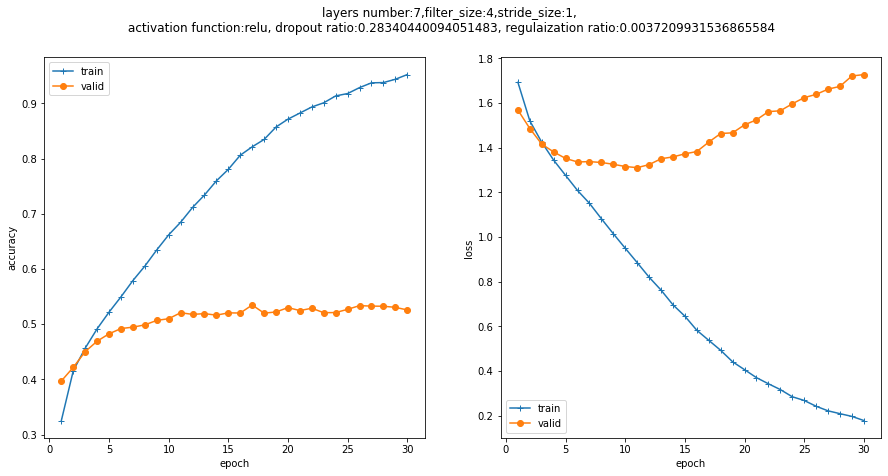

|  1        |  0.5258   |  0.2834   |  4.441    |  7.0      |  0.003721 |  1.147    |
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
6_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
__________________________________

<Figure size 432x288 with 0 Axes>

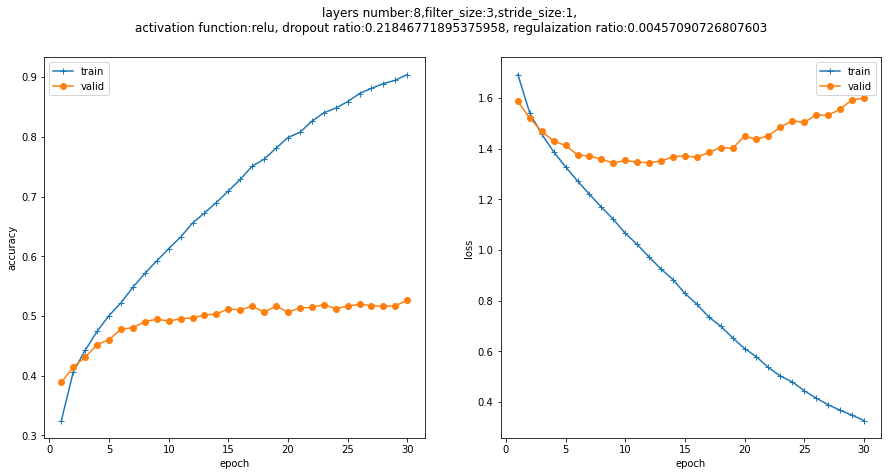

|  2        |  0.5266   |  0.2185   |  3.373    |  8.037    |  0.004571 |  1.539    |
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        544       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        16416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________________________________

<Figure size 432x288 with 0 Axes>

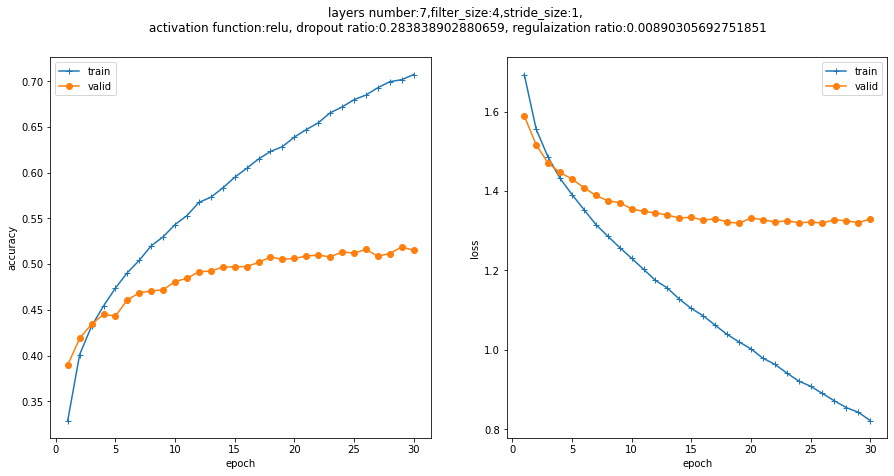

|  3        |  0.5152   |  0.2838   |  4.37     |  7.613    |  0.008903 |  1.027    |
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
6_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
__________________________________

<Figure size 432x288 with 0 Axes>

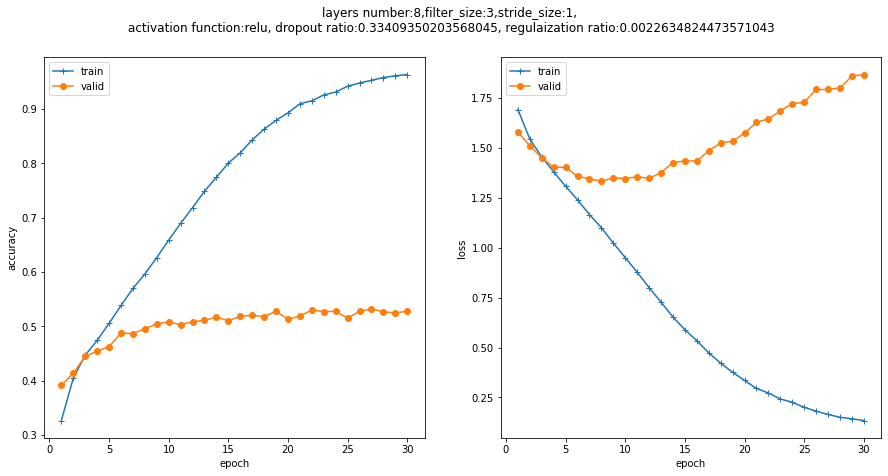

|  4        |  0.528    |  0.3341   |  3.835    |  8.676    |  0.002263 |  1.198    |
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        544       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        16416     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
__________________________________

<Figure size 432x288 with 0 Axes>

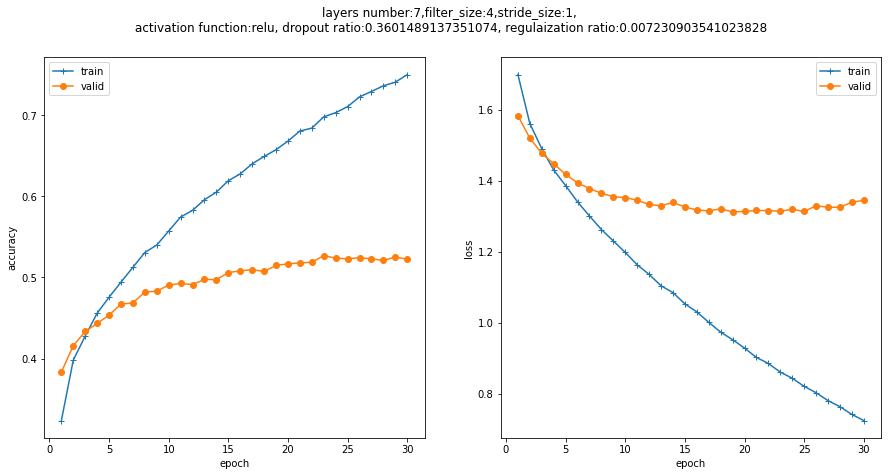

|  5        |  0.5224   |  0.3601   |  4.937    |  7.94     |  0.007231 |  1.876    |
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 24, 24, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 3, 3, 64)          18496     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 64)          0         
__________________________________

<Figure size 432x288 with 0 Axes>

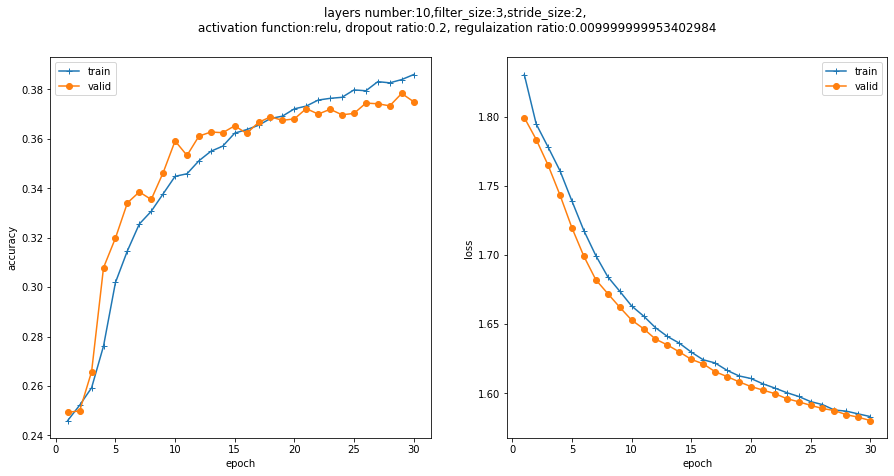

|  6        |  0.375    |  0.2      |  3.0      |  10.0     |  0.01     |  2.0      |
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)        0         
_________________________________

<Figure size 432x288 with 0 Axes>

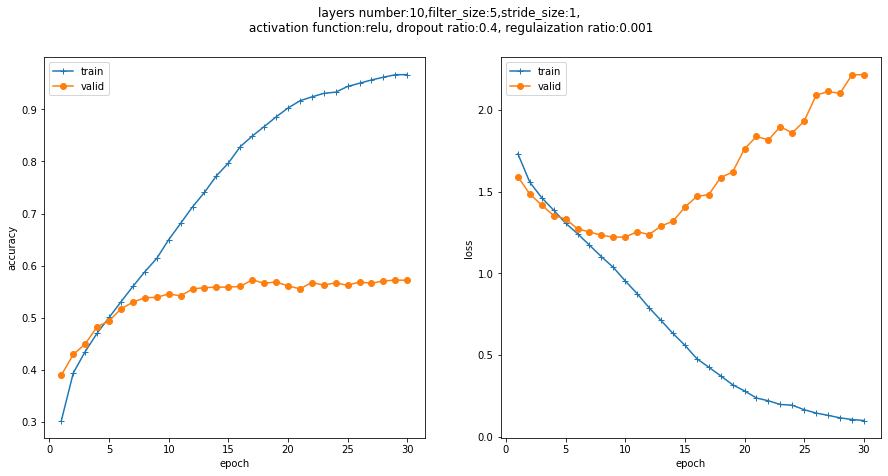

|  7        |  0.572    |  0.4      |  5.0      |  10.0     |  0.001    |  1.0      |
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 18432)             0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               9437696   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________

<Figure size 432x288 with 0 Axes>

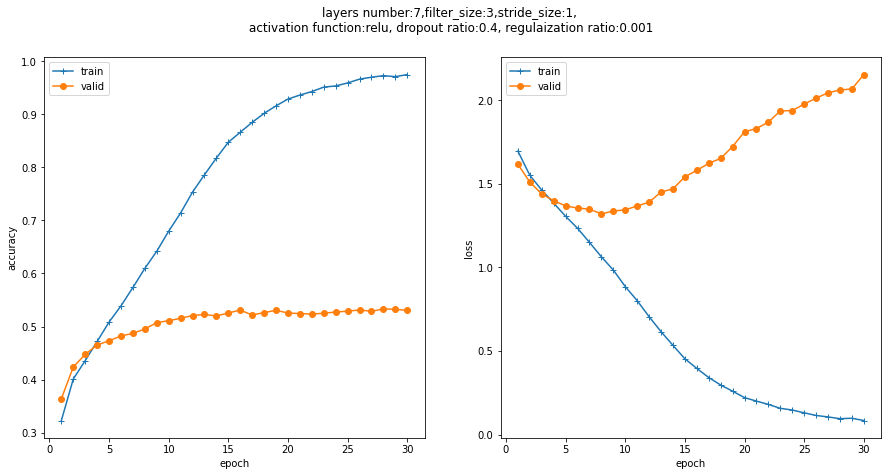

|  8        |  0.5305   |  0.4      |  3.0      |  7.0      |  0.001    |  1.0      |
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 24, 24, 32)        320       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1152)              0         
_________________________________________________________________
5_hidden_layer (Dense)       (None, 512)               590336    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________

<Figure size 432x288 with 0 Axes>

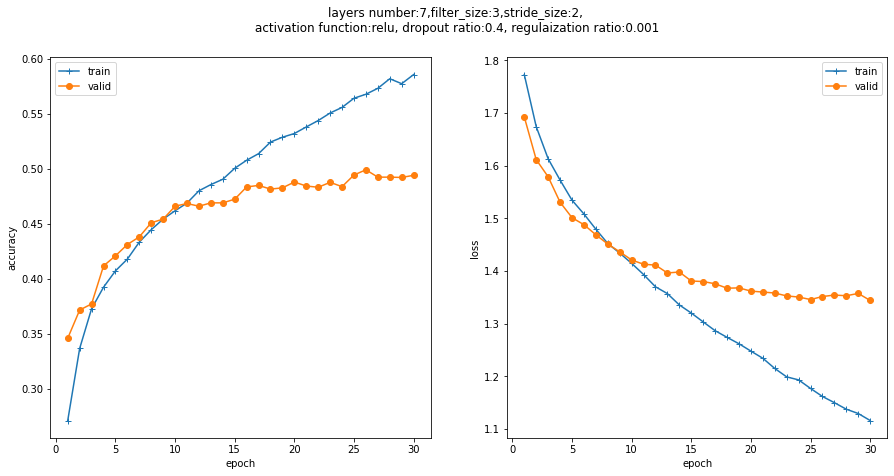

|  9        |  0.494    |  0.4      |  3.0      |  7.0      |  0.001    |  2.0      |
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 24, 24, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 12, 12, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 3, 3, 64)          51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 2, 2, 64)          102464    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 1, 64)          0         
_________________________________

<Figure size 432x288 with 0 Axes>

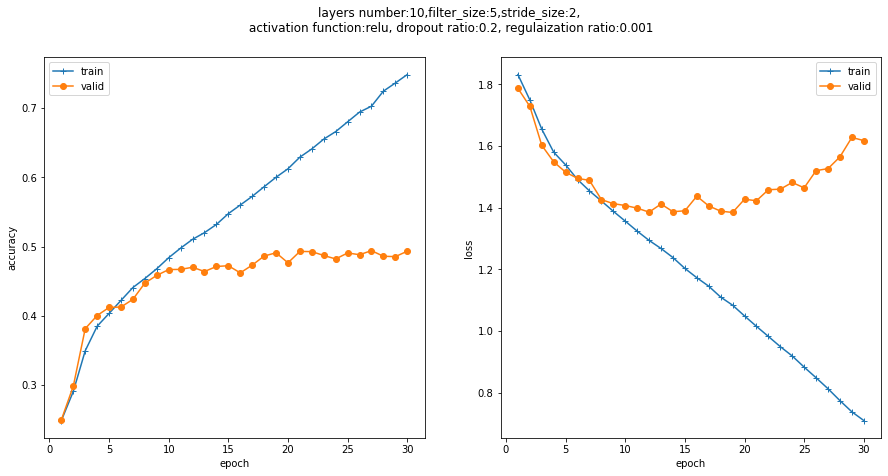

|  10       |  0.4932   |  0.2      |  5.0      |  10.0     |  0.001    |  2.0      |


<Figure size 432x288 with 0 Axes>

In [29]:
optimizer.maximize(
    init_points=5,
    n_iter=5,
)

In [30]:
print(optimizer.max)# 259 13
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

{'target': 0.5720256567001343, 'params': {'dropout_ratio': 0.4, 'filter_size': 5.0, 'num_layers': 10.0, 'regulaize_ratio': 0.001, 'stride_size': 1.0}}
Iteration 0: 
	{'target': 0.5257731676101685, 'params': {'dropout_ratio': 0.28340440094051483, 'filter_size': 4.440648986884316, 'num_layers': 7.000343124452034, 'regulaize_ratio': 0.0037209931536865584, 'stride_size': 1.1467558908171132}}
Iteration 1: 
	{'target': 0.5266090631484985, 'params': {'dropout_ratio': 0.21846771895375958, 'filter_size': 3.3725204227553416, 'num_layers': 8.036682181129143, 'regulaize_ratio': 0.00457090726807603, 'stride_size': 1.538816734003357}}
Iteration 2: 
	{'target': 0.5151852965354919, 'params': {'dropout_ratio': 0.283838902880659, 'filter_size': 4.370439000793519, 'num_layers': 7.613356749194552, 'regulaize_ratio': 0.00890305692751851, 'stride_size': 1.0273875931979262}}
Iteration 3: 
	{'target': 0.5280022025108337, 'params': {'dropout_ratio': 0.33409350203568045, 'filter_size': 3.834609604734254, 'num_l

In [34]:
black_box_function(optimizer.max['params']['num_layers'],
                   optimizer.max['params']['filter_size'],
                   optimizer.max['params']['stride_size'],
                   optimizer.max['params']['dropout_ratio'],
                   optimizer.max['params']['regulaize_ratio'],
                   act_func='relu',train_status = False)
#black_box_function(num_layers,filter_size,stride_size, dropout_ratio, regulaize_ratio,act_func='relu',train_status = True)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_hidden_layer (Conv2D)      (None, 48, 48, 32)        832       
_________________________________________________________________
2_hidden_layer (Conv2D)      (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
4_hidden_layer (Conv2D)      (None, 24, 24, 64)        51264     
_________________________________________________________________
5_hidden_layer (Conv2D)      (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 9216)            

[2.218076229095459, 0.5904151797294617]

# 2(f)

In [ ]:
train_fashion_images_3d = train_images_3d
valid_fashion_images_3d = valid_images_3d
test_fashion_images_3d = test_images_3d

for l in common_features:
  l.trainable = False

print(cnn_model.summary())

cnn_model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'],)

train_loss = []
train_acc = []
test_loss = []
test_acc = []
for _ in range(10):
  training = cnn_model.fit(train_fashion_images_3d, to_categorical(train_labels), epochs=2, batch_size=256,)
  performance = cnn_model.evaluate(test_fashion_images_3d, to_categorical(test_labels))
  train_loss.append(training.history['loss'][-1])
  train_acc.append(training.history['accuracy'][-1])
  test_loss.append(performance[0])
  test_acc.append(performance[1]) 
  print("Accuracy on Train samples: {1}, loss:{0}".format(training.history['loss'][-1],training.history['accuracy'][-1]))
  print("Accuracy on Test samples: {0}, loss:{1}".format(performance[1],performance[0]))


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 48, 48, 8)         80        
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 48, 48, 32)        2336      
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 12, 12, 128)     

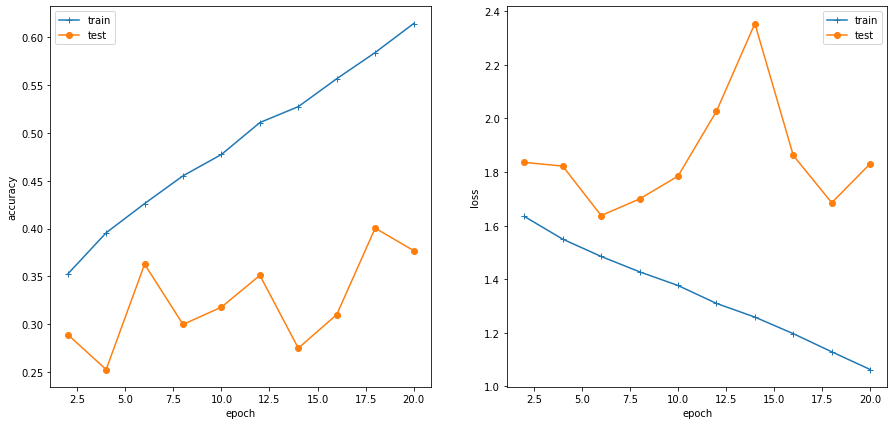

[0.2892170548439026, 0.25271663069725037, 0.36277514696121216, 0.2998049557209015, 0.3179158568382263, 0.3510727286338806, 0.2750069797039032, 0.3101142346858978, 0.400390088558197, 0.37698522210121155]
[1.8356916904449463, 1.821903109550476, 1.637377142906189, 1.6994293928146362, 1.784424066543579, 2.0262598991394043, 2.3534445762634277, 1.861594557762146, 1.6852104663848877, 1.8306745290756226]
0.36277514696121216 1.637377142906189


In [ ]:
x_aix = np.linspace(2,20,10)
fig = plt.figure(figsize=(15,7))
a = fig.add_subplot(1,2,1)
plt.plot(x_aix,train_acc,'+-',x_aix,test_acc,'o-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])

a = fig.add_subplot(1,2,2)
plt.plot(x_aix,train_loss,'+-',x_aix,test_loss,'o-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])

plt.show()
print(test_acc)
print(test_loss)
print(test_acc[np.argmin(test_loss)],np.min(test_loss))